# The real reason zip code data is challenging

## Background

An analysis of Pennsylvania zip code and municipal maps as an illustration of the challenges of working with zip code data.

## Outline
* Use Abington Township in Pennsylvania as an example
* Explanation of why this is a problem
* Show that this is not unusual (poor overlap between zip codes and towns across the state)

## Setup

### Libraries
* numpy - for some array manipulation
* pandas - basic data manipulation functionality
* matplotlib - whole library to expand plotting functionality
* plt from matplotlib - basic charting functionality
* geopandas - python's gis manipulation and plotting framework
* Polygon from shapely - needed to calculate area of overlap between municipal and zip code maps
* random - used to shuffle colors for zipcode map


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Polygon, Point
import random

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Global variables

* townPop - Abington Township 2023 population estimate
* paProjection - the epsg number for a projection that works well for the US mid-atlantic and uses the units meters. 
* sqMet_to_sqMi - conversion factor to convert m<sup>2</sup> to Mi<sup>2</sup>
* tab20_colors - a set of 20 distinct colors for mapping many features
* tab20_hex - a list of 20 colors as hex codes



In [2]:
townPop = 58451

paProjection = 3362
sqMet_to_sqMi = 2.59e+6

tab20_colors = matplotlib.colormaps['tab20']
tab20_hex = [matplotlib.colors.rgb2hex(tab20_colors(i)) for i in range(tab20_colors.N)]

### Helper functions

* formatVal(v): formats large numbers by adding commas
* validate_geometry: early versions of this analysis identifed some issues with the map features. This function applies the buffer(0) feature of geopandas to fix the issues. 
* makeRandomPalette: takes a number (n) and returns a list of hex codes from tab20 the lenght of n

In [3]:
def formatVal(v):
  return format(v, ',')

def validateGeometry(geom):
    if not geom.is_valid:
        return geom.buffer(0)
    return geom


def makeRandomPalette(n):
   
  if n > len(tab20_hex):
      num_repeats = ( n // len(tab20_hex)) + 1
      rndColors = (tab20_hex * num_repeats)[:n]
  else:
      rndColors = tab20_hex

  random.shuffle(rndColors) 

  return rndColors

### Data sources

* munPA - [Pennsylvania municipal boundaries](https://www.pasda.psu.edu/uci/DataSummary.aspx?dataset=41) downloaded 2024-07-06 from the Pennsylvania Atlas
* zipPA - [US zip code boundaries](https://hub.arcgis.com/datasets/d6f7ee6129e241cc9b6f75978e47128b/explore) downloaded 2024-07-06 from ESRI ArcGIS Data Hub
* Abington Township population estimate in 2023: <strong><span style='color:gold;'>58,451</span></strong> source: [US Census Bureau](https://www.census.gov/quickfacts/fact/table/abingtontownshipmontgomerycountypennsylvania/RHI225222)

<div style='text-align: center; width: 75%; margin: 0 auto; padding: 15px; background: #bfbfff; border-radius: 5px;'><strong><span style='color:red;'>Note:</span><br /></strong> <span style='color:#121267;'>this repo does not contain the data. In order to replicate the charts, the two .shp file need to be downloaded and unziped from the sources linked above</span></div>

In [4]:
munPA = gp.read_file('./PaMunicipalities2024_05/PaMunicipalities2024_05.shp')
zipPA = gp.read_file('./USA_ZIP_Code_Boundaries/USA_ZIP_Code_Boundaries.shp') # this contains data for the entire country

# limit zipcode map to just Pennsylvania
zipPA = zipPA[zipPA['STATE'] == 'PA']

# make sure maps have an appropriate projection for PA
munPA.to_crs(epsg= paProjection, inplace=True)
zipPA.to_crs(epsg= paProjection, inplace=True)

In [5]:
# check and fix issues with geometry
munPA['geometry'] = munPA['geometry'].apply(validateGeometry)
zipPA['geometry'] = zipPA['geometry'].apply(validateGeometry)

## Assess the map data
Summary of data

In [6]:
print('the state municipal data contains information on', formatVal(len(munPA)), 'municipalities')
print('the state zip code data contains information on', formatVal(len(zipPA)), 'zip codes')

the state municipal data contains information on 2,571 municipalities
the state zip code data contains information on 1,700 zip codes


In [7]:
# quick check to confirm that the zip code data contains a single row for every zip code. 
len(zipPA['ZIP_CODE'].unique())

1700

Check the maps:

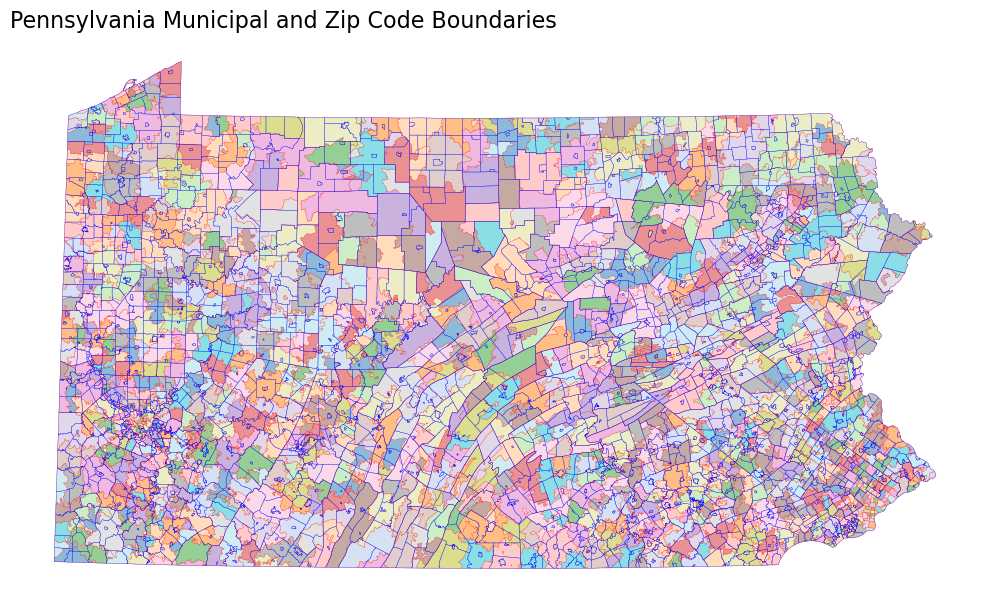

In [8]:
# low rez version of the map
fig, ax = plt.subplots(
  figsize=(10,6.8)
)

mapColors = makeRandomPalette(len(zipPA))

abingtonSHP = munPA[munPA['MUNICIPAL1'] == 'ABINGTON']

xMin, yMin, xMax, yMax = abingtonSHP.total_bounds

plt.title('Pennsylvania Municipal and Zip Code Boundaries', fontsize=16, loc='left')

ax.set_axis_off()
zipPA.plot(ax=ax, color=mapColors, edgecolor='#ff0000', linewidth=.25, alpha=0.5)
munPA.plot(ax=ax, color='none', edgecolor='#0000ff', linewidth=.2, alpha=0.9) 

plt.tight_layout()

plt.savefig('paZipAndMunMap_sm.png', dpi=192)

plt.show()



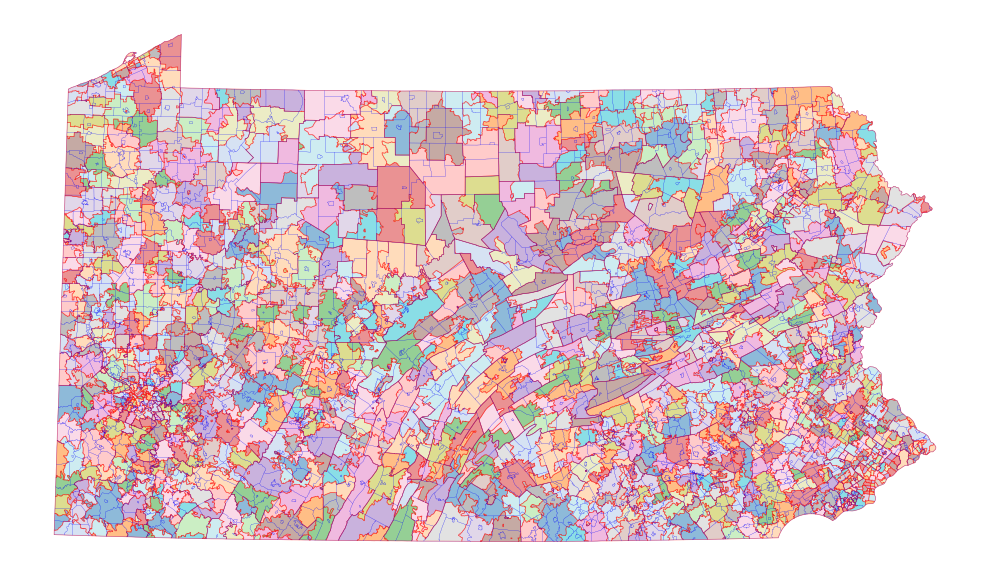

In [9]:
# high rez version of the map
fig, ax = plt.subplots(
  figsize=(10,6.8)
)

mapColors = makeRandomPalette(len(zipPA))

abingtonSHP = munPA[munPA['MUNICIPAL1'] == 'ABINGTON']

xMin, yMin, xMax, yMax = abingtonSHP.total_bounds

# plt.title('Pennsylvania Municipal and Zip Code Boundaries', fontsize=16, loc='left')

ax.set_axis_off()
zipPA.plot(ax=ax, color=mapColors, edgecolor='#ff0000', linewidth=.5, alpha=0.5)
munPA.plot(ax=ax, color='none', edgecolor='#0000ff', linewidth=.1, alpha=0.9) 

plt.tight_layout()

plt.savefig('paZipAndMunMap_mid.png', dpi=192)

plt.show()



Key: 
* Municipal boundaries - blue lines
* Zip codes - randomly colored areas with red borders

At this scale it is difficult to see detail, but it shows that the there are many cases where the blue municipal borders do not map onto the red zip code boundaries. 

The township used as an example below is Abington PA. It is in the lower right corner and is shown in red.

___

## Map of example town

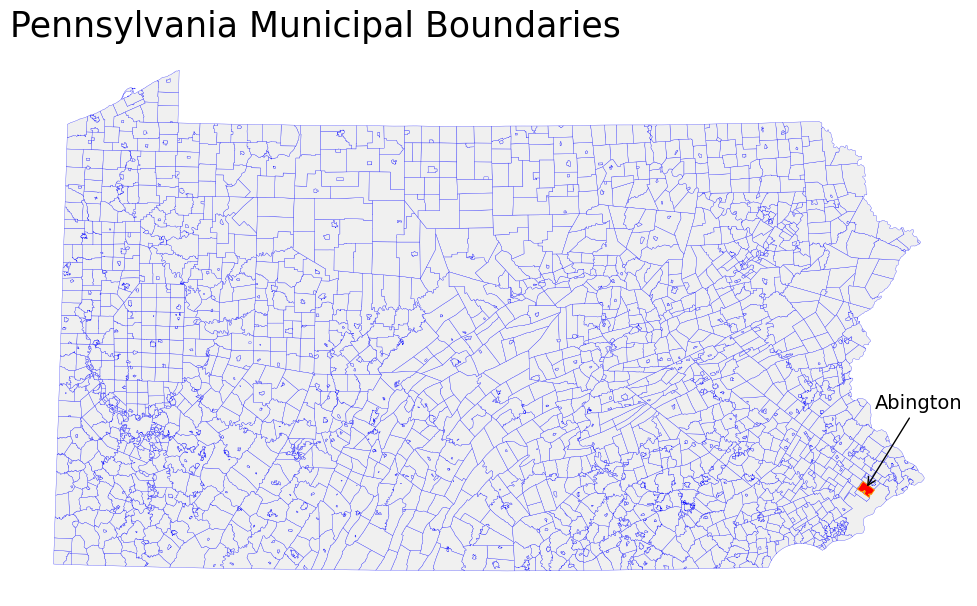

In [10]:
fig, ax = plt.subplots(
  figsize=(10,6.8)
)

mapColors = makeRandomPalette(len(zipPA))

abingtonSHP = munPA[munPA['MUNICIPAL1'] == 'ABINGTON']

xMin, yMin, xMax, yMax = abingtonSHP.total_bounds

plt.title('Pennsylvania Municipal Boundaries', fontsize=25, loc='left')

ax.set_axis_off()
# zipPA.plot(ax=ax, color=mapColors, edgecolor='#ff0000', linewidth=.25, alpha=0.5)
munPA.plot(ax=ax, color='#efefef', edgecolor='#0000ff', linewidth=.2, alpha=0.9) 
abingtonSHP.plot(ax=ax, color='red', edgecolor='orange', linewidth=.6, alpha=1)

ax.annotate('Abington', xy=((xMin + xMax)/2, (yMin + yMax)/2), xytext=(xMin + 1e4, yMin + 5e4), size=14, 
            arrowprops=dict(arrowstyle='->'))

plt.tight_layout()

plt.savefig('paMunAbington_sm.png', dpi=192)

plt.show()


Map of Abington showing the location in PA

___

Map showing Abington township and Abington Zip code. 

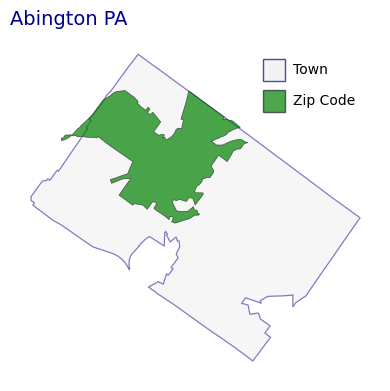

In [11]:
fig, ax = plt.subplots(
  figsize=(4,4)
)

mapColors_02 = makeRandomPalette(len(munPA))

abingtonSHP = munPA[munPA['MUNICIPAL1'] == 'ABINGTON'].reset_index(drop=True)
abingtonZIP = zipPA[zipPA['PO_NAME'] == 'Abington'].reset_index(drop=True)

xMin, yMin, xMax, yMax = abingtonSHP.total_bounds

mapBorderAdj = 600

ax.set_axis_off()
ax.set_xlim(xMin - mapBorderAdj, xMax + mapBorderAdj)
ax.set_ylim(yMin - mapBorderAdj, yMax + mapBorderAdj)

plt.title('Abington PA', fontsize=14, loc='left', color='darkblue')


# munPA.plot(ax=ax, color=mapColors_02, edgecolor='none', linewidth=.5, alpha=0.1) 
# munPA.plot(ax=ax, color='none', edgecolor='#232323', linewidth=.5, alpha=1) 
 
abingtonSHP.plot(ax=ax, color='#efefef', edgecolor='darkblue', linewidth=0.9, alpha=0.5)
abingtonZIP.plot(ax=ax, color='green', edgecolor='#232323', linewidth=.5, alpha=0.7)

ax.annotate(
    '   ', xy=(xMax - mapBorderAdj*4.5, yMax-mapBorderAdj*2.5), xycoords='data',
    bbox=dict(boxstyle='square,pad=0.3', edgecolor='#232323', facecolor='green', alpha=0.7)
)

ax.annotate(
    'Zip Code', xy=(xMax - mapBorderAdj*3.25, yMax-mapBorderAdj*2.5), xycoords='data'
)

ax.annotate(
    '   ', xy=(xMax - mapBorderAdj*4.5, yMax-mapBorderAdj), xycoords='data',
    bbox=dict(boxstyle='square,pad=0.3', edgecolor='darkblue', facecolor='#efefef', alpha=0.7)
)

ax.annotate(
    'Town', xy=(xMax - mapBorderAdj*3.25, yMax-mapBorderAdj), xycoords='data'
)

plt.tight_layout()

plt.savefig('AbingtonPA.png', dpi=150)

plt.show()

In [12]:
print('population:',formatVal(round(abingtonZIP['POPULATION'].values[0])))
print('area:',abingtonZIP['SQMI'].values[0], 'square miles')


population: 18,129
area: 3.55 square miles


### Map of town showing zip code coverage

Find zip codes that overlap Abington

In [13]:
zipPA['zipTotalArea'] = zipPA['geometry'].area / sqMet_to_sqMi

intersects = zipPA[zipPA.geometry.apply(lambda x: abingtonSHP.geometry.intersects(x).any())]
print(len(intersects), 'intersecting zip codes found')


10 intersecting zip codes found


The first pass shows that there are 10 zip codes that touch the target municipality. 

Since the municiaplity and zip code maps are from different sources some of the overlap is due to variations in where the borders have been drawn. 

To address this we need to calculate intersecting area and percentages, and remove all intersections below some threshold. 

In [14]:
abingtonGeom = abingtonSHP.iloc[0]['geometry']
abingtonGeomArea = abingtonGeom.area/sqMet_to_sqMi

# Calculate intersecting area and percentages
intersects = intersects.copy()

intersects['intersectArea'] = intersects['geometry'].apply(lambda x: x.intersection(abingtonGeom).area / sqMet_to_sqMi)
intersects['pctAbingtonInZip'] = 100 * intersects['intersectArea'] / abingtonGeomArea
intersects['pctZipInAbington'] = 100 * intersects['intersectArea'] / intersects['zipTotalArea']

# Filter out small overlaps
intersects = intersects[intersects['pctZipInAbington'] > 1]

print('After eliminating small overlaps there are', len(intersects), 'overlapping zip codes')


After eliminating small overlaps there are 6 overlapping zip codes


In [15]:
# set up zip codes for mapping for labeling by calculating a central point for the label
intersects['coords'] = intersects['geometry'].apply(lambda x: x.representative_point().coords[:])
intersects['coords'] = [coords[0] for coords in intersects['coords']]

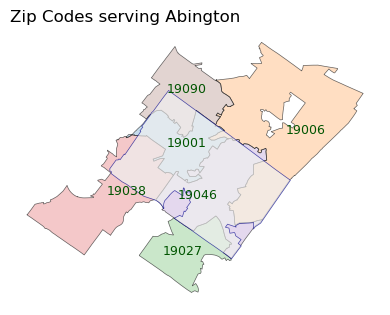

In [16]:
fig, ax = plt.subplots(
  figsize=(4,4)
)

tab10 = plt.get_cmap('tab10')
categories = intersects['ZIP_CODE'].unique()
mapColors_03 = [tab10(i % 10) for i, category in enumerate(categories)]

abingtonSHP = munPA[munPA['MUNICIPAL1'] == 'ABINGTON'].reset_index(drop=True)

lonMin, latMin, lonMax, latMax = abingtonSHP.total_bounds

ax.set_axis_off()

plt.title('Zip Codes serving Abington', fontsize=12, loc='left')

for idx, row in intersects.iterrows():
  ax.text(row.coords[0], row.coords[1], s=row['ZIP_CODE'], horizontalalignment='center', fontsize=9, color='#005400', bbox={'facecolor': 'none', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})


intersects.plot(ax=ax, color=mapColors_03, edgecolor='none', linewidth=.5, alpha=0.25) 
intersects.plot(ax=ax, color='none', edgecolor='#232323', linewidth=.5, alpha=.7) 
abingtonSHP.plot(ax=ax, color='#efefef', edgecolor='darkblue', linewidth=.5, alpha= .7)
# abingtonSHP.plot(ax=ax, color='none', edgecolor='darkblue', linewidth=0.5, alpha= .25)

plt.tight_layout()

plt.savefig('abingtonZips.png', dpi=150)

plt.show()


In [17]:
intersects[['ZIP_CODE','PO_NAME', 'pctZipInAbington']]

,ZIP_CODE,PO_NAME,pctZipInAbington
5796,19001,Abington,98.396368
5800,19006,Huntingdon Valley,17.675034
5817,19027,Elkins Park,18.314777
5826,19038,Glenside,32.397819
5831,19046,Jenkintown,82.947059
5859,19090,Willow Grove,23.061250


The map shows the overlap of the 6 zip codes with Abington town lines, and the table shows the percent the area of each zip code that is within the town. 

In [18]:
totalZipPop = intersects['POPULATION'].sum()
formattedZipPop = formatVal(int(totalZipPop))
formattedTownPop = formatVal(int(townPop))

print('The total area covered by the six zip codes is ' + formattedZipPop + '.')
print('which is more than double the actual population of Abintion of ' + formattedTownPop)


The total area covered by the six zip codes is 132,803.
which is more than double the actual population of Abintion of 58,451


## Statewide analysis of municpal and zip code overlaps

In [19]:
# the municipality dataset does not have a clear unique ids, so create one with county and town name

munPA['uniqueID'] = munPA['COUNTY'] + '_' + munPA['MUNICIPAL_']

# create calculations of total area in km^2
munPA['munTotalArea'] = munPA['geometry'].area/1e6
zipPA['munTotalArea'] = zipPA['geometry'].area/1e6




In [20]:
# for each municipality, find the zip codes that overlap

# create a list of municipalities using the unique id
municipalList = munPA['uniqueID'].to_list()

# create a list zip codes for each municipality
municipalZipOverlaps = []

for _, m in munPA.iterrows():
  tmpZipDF = zipPA[zipPA.intersects(m['geometry'])]
  tmpZipList = tmpZipDF['ZIP_CODE'].tolist()
  municipalZipOverlaps.append({'municipality': m['uniqueID'], 'zipcodes': tmpZipList})

In [21]:
# set up to create a new dataframe that contains a row for each overlapping zip code - municipal pair
newDFCols =['municipalityID', 'zipCode', 'zipsArea', 'munsArea', 'pctOverlap', 'pctOfZipInMun', 'pctOfMunInZip', 'zipCount']

overlapList = []

munAreaDF = munPA.copy()
munAreaDF.to_crs(epsg=32610, inplace=True)

zipAreaDF = zipPA.copy()
zipAreaDF.to_crs(epsg=32610, inplace=True)



for el in municipalZipOverlaps:
  targetMun = el['municipality']
  munGeom = munAreaDF[munAreaDF['uniqueID'] == targetMun]['geometry'].reset_index(drop=True)
  munGeom = munGeom.values[0]

  munArea = munGeom.area/1e6
  zipCount = len(el['zipcodes'])

  for z in el['zipcodes']:
    zipGeom = zipAreaDF[zipAreaDF['ZIP_CODE'] == z]['geometry'].reset_index(drop=True)
    zipGeom = zipGeom.values[0]

    zipArea = zipGeom.area/1e6

    #calculate 
    tmpIntersection = munGeom.intersection(zipGeom)
    tmpIntersectionArea = tmpIntersection.area/1e6

    zipInMun = 100 * tmpIntersectionArea / munArea
    munInZip = 100 * tmpIntersectionArea / zipArea

    overlapList.append({
      'municipalityID': targetMun,
      'zipCode': z,
      'zipsArea': zipArea,
      'munsArea': munArea, 
      'pctOverlap': tmpIntersectionArea,
      'pctOfMunInZip': zipInMun,
      'pctOfZipInMun':munInZip, 
      'zipCount': zipCount
    })

paOverlapDF = pd.DataFrame(overlapList, columns=newDFCols)    
  


In [22]:
# clean up the database: 

paOverlapDF_mod = paOverlapDF.copy()
paOverlapDF_mod = paOverlapDF_mod[paOverlapDF_mod['pctOfZipInMun'] > 3] # get rid of small overlaps based on uneven line drawing

paOverlapDF_mod = paOverlapDF_mod[~paOverlapDF_mod['municipalityID'].isin(['64_209', '67_301', '02_301'])]
paOverlapDF_mod['zipCount'] =paOverlapDF_mod.groupby('municipalityID')['municipalityID'].transform('count')


In [23]:
print('After removing three messy municipalities and all small overlaps the average number of zip codes per municipality is: ',round(paOverlapDF_mod['zipCount'].mean(), 1))

After removing three messy municipalities and all small overlaps the average number of zip codes per municipality is:  3.2


___

To calculate the municipalities that may be able to be analyzed using zip code data we need to find all areas where the combined zipcode area has a large overlap with the municipality. 

This is not easy because the two maps don't line up perfectly so it will be hard to tell if the lack of overlap is an artifact of the use of the two maps. 



In [24]:
# start with grouping the overlap data by municipality
groupedByMun = paOverlapDF_mod.groupby('municipalityID')

In [25]:
# loop through the groups
# merge the zip code areas
# calculate the overlap with the municipality and the percent overlap of  both
# the zip over the mun and the mun over the zip 
# If BOTH of these are above some threshold
# then it will be added to the list of possible good matches. 

matchThreshold = 85

munsWithUsefulZips = []

# loop through the municipalities
for l, m in groupedByMun:
  tmpZipList = m['zipCode'].tolist()

  # get target zip code areas
  tmpZipsDF = zipPA[zipPA['ZIP_CODE'].isin(tmpZipList)].reset_index(drop=True)

  # get the shape and area of the merged zips
  tmpMergedZipsGeom = tmpZipsDF.unary_union
  tmpMergedZipsArea = tmpMergedZipsGeom.area/1e6

  # get the shape and area of the target municipality
  tmpMunGeom = munPA[munPA['uniqueID'] == l]['geometry'].reset_index(drop=True)
  tmpMunArea = tmpMunGeom.area/1e6
  
  # calculate the intersection
  tmpIntersect = tmpMergedZipsGeom.intersection(tmpMunGeom).area/1e6
  tmpIntersect = tmpIntersect.values[0]

  # calculate the percent overlap
  zipInMun = 100 * tmpIntersect / tmpMunArea
  munInZip = 100 * tmpIntersect / tmpMergedZipsArea
  zipInMun = zipInMun.values[0]

  # of percent overlap is high for both the zip in the municipality and the municipality in the zip add to list
  if (munInZip >= matchThreshold) & (zipInMun >= matchThreshold):
    munsWithUsefulZips.append(l)  



In [26]:
print('At a target threshhold of ' + str(matchThreshold) + '%, there are ' + str(len(munsWithUsefulZips)) + ' municipality/zip code area overlaps that might allow for zip code data to be representative of the municipality')

At a target threshhold of 85%, there are 50 municipality/zip code area overlaps that might allow for zip code data to be representative of the municipality
